
# Paddy Disease Classification — **PyTorch + timm**

This is a **minimal, beginner-friendly** image classification pipeline using **PyTorch** and **[timm](https://github.com/huggingface/pytorch-image-models)** (Torch Image Models).  
Typical steps:

1) Setup & configuration  
2) Dataset & transforms (train/valid split)  
3) Model (transfer learning with `timm.create_model`)  
4) Training loop (loss/optimizer)  
5) Evaluation & confusion matrix  
6) (Optional) Inference on test set + `submission.csv`

> **Note:** Point `DATA_DIR` to your local Kaggle Paddy dataset. 


## 1) Setup & Configuration

In [11]:

# If timm isn't installed, uncomment:
# !pip install timm --quiet

import os, random, math, time
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split

from torchvision import datasets, transforms
import timm

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

DATA_DIR = Path("./data/")  
DATA_DIR_TRAIN = Path("./data/train_images/")
USE_IMAGEFOLDER = False             # set False to use CSV dataset class below

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

import matplotlib.pyplot as plt

#this makes sure that colab instances running this notebook can get to included utils_kp.py
try:
    import utils_kp as ut
except ModuleNotFoundError:
    from urllib.request import urlopen
    import shutil
    url = "https://raw.githubusercontent.com/CNUClasses/471_code/master/week6/utils_kp.py"
    dest = Path("utils_kp.py")
    try:
        # try urllib first (no extra deps)
        with urlopen(url) as response, open(dest, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)
        import utils_kp as ut
    except Exception as e:
        raise RuntimeError(f"Failed to download utils_kp.py from {url}: {e}")
 


Device: cuda


## 1) Get Data

Data comes from <strong><a href="https://www.kaggle.com/competitions/paddy-disease-classification">Paddy Doctor: Paddy Disease Classification</a></strong>.  A Kaggle competition whose goal is to identify the type of disease present in rice paddy leaf images. You can download it directly after signing up for a <a href="https://www.kaggle.com/">Kaggle</a> account.<br>

### (Optional)
A better way to get the data is through the <strong><a href="https://www.kaggle.com/docs/api">Kaggle CLI (command line interface)</a></strong>.<br>
It lets you programatically interact with Kaggle (get/browse datasets and competitions and submit results)<br>
BTW- you need to have an API key in order to use the CLI, to get one:<br>
Scroll to the API section in your Account settings and click the Create New API Token button.<br>
Kaggle will generate a JSON file named kaggle.json and prompt you to save the file to your computer.<br>
Put this file in the ~/.kaggle directory on your machine, make sure its only readable by you (chmod 600 /root/.kaggle/kaggle.json)<br>
The CLI looks in this place for your key.<br>



In [12]:
# !pip install --upgrade kaggle  #upgrade or install kaggle CLI
# !mkdir -p ~/.kaggle  #create a place for kaggle.json file
# get the key from above, download it and place it in ~/.kaggle/kaggle.json

# the \" below ensures the " marks are written to the file
# {"username":"kperkins411","key":"99914baaed4f708632c750296a5fee1e"}
# !echo "{\"username\":\"youruserid\",\"key\":\"yourkey\"}" > ~/.kaggle/kaggle.json


In [13]:
# !kaggle datasets list #active competitions
# !kaggle datasets list -s paddy-disease-classification  #the one we want
# !kaggle competitions download -c paddy-disease-classification #get it
# !unzip paddy-disease-classification.zip -d ./data/  #unzip it


## 2) Create datasets with timm transforms 

If your data follows the Kaggle layout (`train_images/` and `train.csv` with `image_id,label`), use this dataset class.  



In [29]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

# MODEL_NAME = "resnet18"  # try: 'efficientnet_b0', 'convnext_tiny', 'mobilenetv3_large_100', ...
MODEL_NAME = 'convnext_tiny'
config = timm.data.resolve_data_config({}, model=MODEL_NAME)
train_tfms = timm.data.create_transform(**config, is_training=True, hflip=0.5, auto_augment=None)
valid_tfms = timm.data.create_transform(**config, is_training=False)

pp.pprint(config)

{   'crop_mode': 'center',
    'crop_pct': 0.875,
    'input_size': (3, 224, 224),
    'interpolation': 'bicubic',
    'mean': (0.485, 0.456, 0.406),
    'std': (0.229, 0.224, 0.225)}


In [15]:
from sklearn.model_selection import StratifiedShuffleSplit


full_ds = datasets.ImageFolder(DATA_DIR_TRAIN, transform=train_tfms)
n_total = len(full_ds)
print(f"Total images: {n_total}")
n_valid = int(0.1 * n_total)
n_train = n_total - n_valid
targets = np.array(full_ds.targets)
sss = StratifiedShuffleSplit(n_splits=1, test_size=n_valid, random_state=42)
train_idx, valid_idx = next(sss.split(np.arange(n_total), targets))

train_ds = torch.utils.data.Subset(full_ds, train_idx)
valid_ds = torch.utils.data.Subset(full_ds, valid_idx)
#should be stratified split, but close enough for now
# train_ds, valid_ds = random_split(full_ds, [n_train, n_valid], generator=torch.Generator().manual_seed(42))
print(f"Train images: {len(train_ds)}")
print(f"Valid images: {len(valid_ds)}")


Total images: 10407
Train images: 9367
Valid images: 1040


## 3) Create Dataloaders

- Shuffle the training loader; keep validation loader deterministic.  
- Adjust `BATCH_SIZE` to fit your GPU/CPU memory.

This is a datascience competition:<br>
the train_images folder contains images with class membership info (in the train.csv file).<br>
the test_images folder contains images that your model infers membership on.  These inferences are bundled into a file (see sample_submission.csv) which is submitted for ranking  

In [16]:

BATCH_SIZE = 64

lr=0.01 #start with this one (its too high see lr finder below)
# lr=2e-3 #lr finder approved this one

train_images = DATA_DIR / "train_images"
train_csv    = DATA_DIR / "train.csv"
class_names = list(full_ds.class_to_idx.keys())
num_classes = len(class_names)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)

# print(f"Classes ({num_classes}):", class_names[:10], "..." if num_classes>10 else "")
print("Train/Valid sizes:", len(train_ds), len(valid_ds))


Train/Valid sizes: 9367 1040


### Look at a few of the images

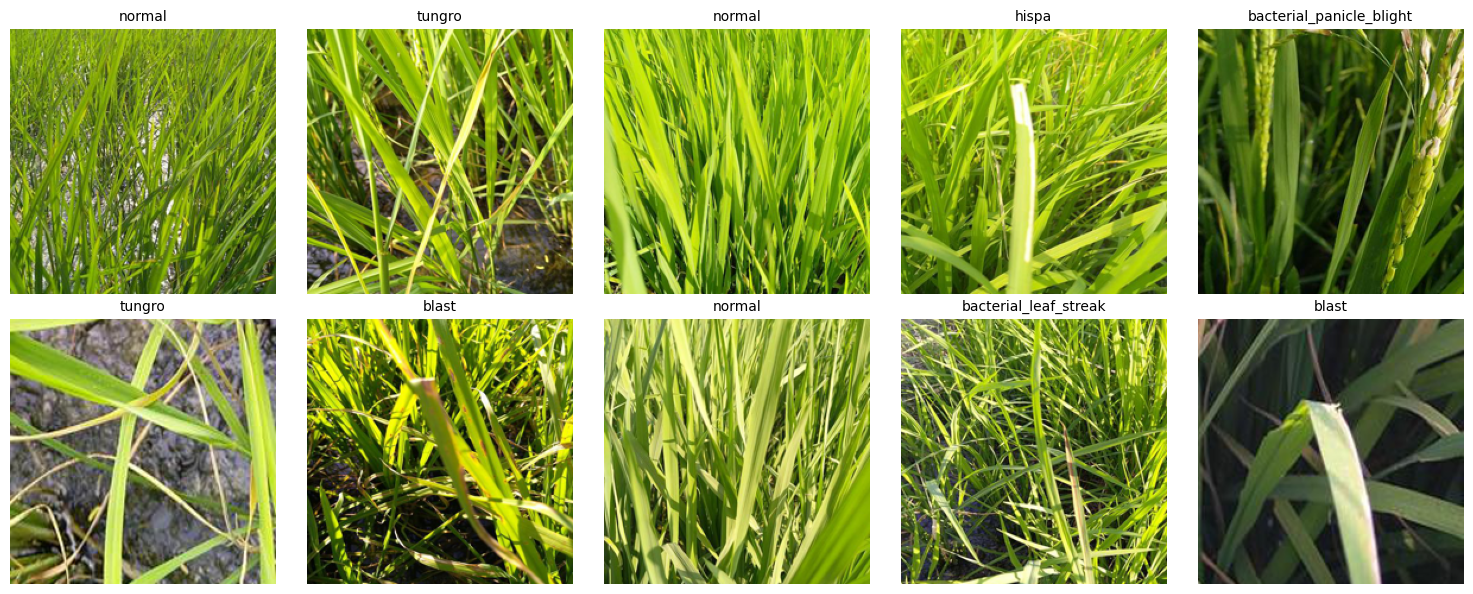

In [17]:
# Display first 10 images + class names from train_loader
# Uses existing variables: train_loader, class_names, config, plt, np, torch

batch = next(iter(train_loader))
xb, yb = batch
num = min(10, xb.size(0))

imgs = xb[:num].clone()  # shape: (num, 3, H, W)
labels_idx = yb[:num].tolist()
labels = [class_names[i] for i in labels_idx]

# un-normalize using config mean/std (expects (3,) tuples)
mean = torch.tensor(config['mean']).view(3, 1, 1)
std = torch.tensor(config['std']).view(3, 1, 1)

# imgs are on CPU (from dataloader); if not, move mean/std to same device
mean = mean.to(imgs.device)
std = std.to(imgs.device)

# create subplots (2 rows x 5 cols)
cols = 5
rows = int(np.ceil(num / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
axes = axes.flatten()

for i in range(rows * cols):
    ax = axes[i]
    if i < num:
        img = imgs[i] * std + mean  # unnormalize
        npimg = img.numpy().transpose(1, 2, 0)
        npimg = np.clip(npimg, 0, 1)
        ax.imshow(npimg)
        ax.set_title(labels[i], fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 4) Load timm Model (Transfer Learning with **timm**)

- Create a **pretrained** model with `num_classes` = 10 (PaddyDoctor classes).  
- **Warm-up:** freeze backbone; train the classifier head first.



In [18]:

model=ut.make_model(MODEL_NAME, num_classes, device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)


In [19]:
#make sure just training the last layer
for name, p in model.named_parameters():
    print (f'Name={name},p.shape={p.shape}, p.requires_grad = {p.requires_grad}')


Name=stem.0.weight,p.shape=torch.Size([96, 3, 4, 4]), p.requires_grad = False
Name=stem.0.bias,p.shape=torch.Size([96]), p.requires_grad = False
Name=stem.1.weight,p.shape=torch.Size([96]), p.requires_grad = False
Name=stem.1.bias,p.shape=torch.Size([96]), p.requires_grad = False
Name=stages.0.blocks.0.gamma,p.shape=torch.Size([96]), p.requires_grad = False
Name=stages.0.blocks.0.conv_dw.weight,p.shape=torch.Size([96, 1, 7, 7]), p.requires_grad = False
Name=stages.0.blocks.0.conv_dw.bias,p.shape=torch.Size([96]), p.requires_grad = False
Name=stages.0.blocks.0.norm.weight,p.shape=torch.Size([96]), p.requires_grad = False
Name=stages.0.blocks.0.norm.bias,p.shape=torch.Size([96]), p.requires_grad = False
Name=stages.0.blocks.0.mlp.fc1.weight,p.shape=torch.Size([384, 96]), p.requires_grad = False
Name=stages.0.blocks.0.mlp.fc1.bias,p.shape=torch.Size([384]), p.requires_grad = False
Name=stages.0.blocks.0.mlp.fc2.weight,p.shape=torch.Size([96, 384]), p.requires_grad = False
Name=stages.0.bl

In [20]:
#stopped here 9/29/25
print(model)

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)



## 5) Optimizer & loss 


In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

### (Optional) Use the learning rate finder to help set initial Learning Rate

For a sweep of learning rates, reinitialize the model for each rate, train for a **few batches**, and save (learning rate, loss). <br>
When done plot the loss versus learning rate, then choose the largest learning rate on the descending slope—just before the loss starts rising.

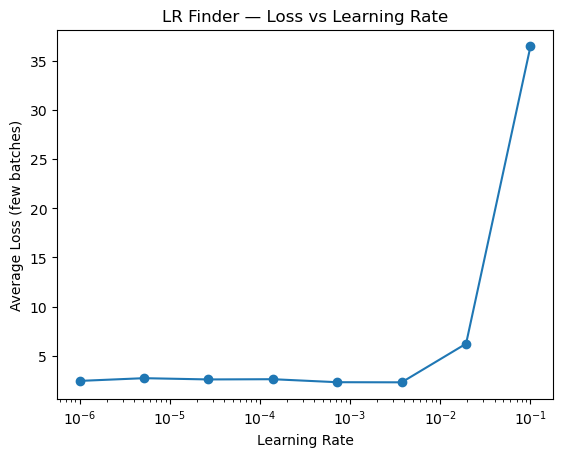

(0.0037275937203149418, 2.3046396493911745)

In [22]:

lr_candidates = np.logspace(-6, -1, num=8)
finder = ut.LearningRateFinder(MODEL_NAME, num_classes, criterion, device)
results = finder.run(lr_candidates, train_loader, num_batches=5)
finder.plot()

best_lr, best_loss = min(results, key=lambda t: t[1])
best_lr, best_loss


# 6) Training & validation loop

- Log train/valid **loss** and **accuracy** per epoch.  
- Keep code short and well-commented.

In [23]:
%%time 

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb) #loss is the avearege over the batch (so multiply by batch size below)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        correct += (logits.argmax(1) == yb).sum().item()
        total += xb.size(0)
    return total_loss/total, correct/total

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)  #loss is the avearege over the batch (so multiply by batch size below)
        total_loss += loss.item() * xb.size(0)
        correct += (logits.argmax(1) == yb).sum().item()
        total += xb.size(0)
    return total_loss/total, correct/total

def train_and_evaluate(model, train_loader, valid_loader, optimizer, criterion, num_epochs=10):
    for epoch in range(1, num_epochs + 1):
        # Train for one epoch
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)

        # Evaluate on validation set
        va_loss, va_acc = evaluate(model, valid_loader, criterion)
        print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | valid loss {va_loss:.4f} acc {va_acc:.3f}")

train_and_evaluate(model, train_loader, valid_loader, optimizer, criterion, num_epochs=5)


Epoch 01 | train loss 1.5056 acc 0.572 | valid loss 1.1424 acc 0.617
Epoch 02 | train loss 1.1175 acc 0.664 | valid loss 1.1007 acc 0.688
Epoch 03 | train loss 1.0117 acc 0.699 | valid loss 0.8847 acc 0.729
Epoch 04 | train loss 0.9291 acc 0.716 | valid loss 1.1756 acc 0.646
Epoch 05 | train loss 0.9277 acc 0.724 | valid loss 1.0451 acc 0.711
CPU times: user 58 s, sys: 9.16 s, total: 1min 7s
Wall time: 2min 57s


### (Optional) Fine-tune the whole network

After warming up the head, unfreeze the backbone and fine-tune at a **smaller LR**.

In [24]:
%%time 

# train the whole thing (unfreeze all layers)
for p in model.parameters():
    p.requires_grad = True

#make lr smaller for fine-tuning
lr1=lr/10

#change learning rate for fine-tuning
for g in optimizer.param_groups:
    g['lr'] = lr1

train_and_evaluate(model, train_loader, valid_loader, optimizer, criterion, num_epochs=5)


Epoch 01 | train loss 0.6341 acc 0.792 | valid loss 0.7354 acc 0.763
Epoch 02 | train loss 0.5828 acc 0.807 | valid loss 0.6953 acc 0.774
Epoch 03 | train loss 0.5830 acc 0.806 | valid loss 0.6961 acc 0.778
Epoch 04 | train loss 0.5750 acc 0.810 | valid loss 0.6492 acc 0.788
Epoch 05 | train loss 0.5763 acc 0.808 | valid loss 0.6514 acc 0.789
CPU times: user 2min 39s, sys: 9.44 s, total: 2min 48s
Wall time: 3min 1s


## 7) Evaluation & Confusion Matrix

In [25]:

@torch.no_grad()
def get_all_preds_targets(model, loader):
    model.eval()
    preds, targs = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb)
        preds.append(logits.argmax(1).cpu().numpy())
        targs.append(yb.numpy())
    return np.concatenate(preds), np.concatenate(targs)

preds, targs = get_all_preds_targets(model, valid_loader)

# Confusion matrix
num_classes = len(class_names)
cm = np.zeros((num_classes, num_classes), dtype=int)
for t, p in zip(targs, preds):
    cm[t, p] += 1

print('Confusion Matrix (6x6 for PaddyDoctor):')
print(cm)

# Per-class metrics
per_class = []
for k in range(num_classes):
    TP = cm[k,k]
    FP = cm[:,k].sum() - TP
    FN = cm[k,:].sum() - TP
    TN = cm.sum() - TP - FP - FN
    prec = TP/(TP+FP) if (TP+FP)>0 else 0.0
    rec  = TP/(TP+FN) if (TP+FN)>0 else 0.0
    f1   = (2*prec*rec)/(prec+rec) if (prec+rec)>0 else 0.0
    per_class.append((prec, rec, f1))

macro_p = float(np.mean([p for p,_,_ in per_class]))
macro_r = float(np.mean([r for _,r,_ in per_class]))
macro_f = float(np.mean([f for _,_,f in per_class]))
overall_acc = float((preds == targs).mean())

print('\nPer-class (precision, recall, f1):')
for name,(p,r,f) in zip(class_names, per_class):
    print(f'{name:>10s}: P={p:.3f} R={r:.3f} F1={f:.3f}')
print(f"\nMacro avg: P={macro_p:.3f} R={macro_r:.3f} F1={macro_f:.3f}")
print(f'Overall Accuracy: {overall_acc:.3f}')


Confusion Matrix (6x6 for PaddyDoctor):
[[ 22   0   0   2   8   1   1   5   2   7]
 [  1  28   0   2   2   0   0   2   1   2]
 [  0   0  28   0   0   5   0   0   1   0]
 [  3   1   0 125  10   1   8  11   5  10]
 [  2   1   1  10  62   2   5   1   3   9]
 [  0   0   0   1   0 137   0   2   4   0]
 [  2   2   0   5   0   0  40   4   1   8]
 [  5   1   0   5   4   1   3 113  13  14]
 [  0   0   1   1   1   4   1   9 154   5]
 [  2   2   0   2   2   1   3   6   1  90]]

Per-class (precision, recall, f1):
bacterial_leaf_blight: P=0.595 R=0.458 F1=0.518
bacterial_leaf_streak: P=0.800 R=0.737 F1=0.767
bacterial_panicle_blight: P=0.933 R=0.824 F1=0.875
     blast: P=0.817 R=0.718 F1=0.765
brown_spot: P=0.697 R=0.646 F1=0.670
dead_heart: P=0.901 R=0.951 F1=0.926
downy_mildew: P=0.656 R=0.645 F1=0.650
     hispa: P=0.739 R=0.711 F1=0.724
    normal: P=0.832 R=0.875 F1=0.853
    tungro: P=0.621 R=0.826 F1=0.709

Macro avg: P=0.759 R=0.739 F1=0.746
Overall Accuracy: 0.768


## 8) (Optional) Inference on Test Set + `submission.csv`

In [26]:

import pandas as pd
from PIL import Image

@torch.no_grad()
def predict_folder_images(img_dir, transform, class_names):
    paths = sorted([p for p in Path(img_dir).glob("*.*") if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp"}])
    ids, labels = [], []
    for p in paths:
        img = Image.open(p).convert("RGB")
        x = transform(img).unsqueeze(0).to(device)
        logits = model(x)
        pred = logits.argmax(1).item()
        ids.append(p.name)
        labels.append(class_names[pred])
    return ids, labels

test_dir_A = DATA_DIR / "test"
test_dir_B = DATA_DIR / "test_images"
sub_path   = DATA_DIR / "submission.csv"

if test_dir_A.exists():
    ids, labels = predict_folder_images(test_dir_A, valid_tfms, class_names)
elif test_dir_B.exists():
    ids, labels = predict_folder_images(test_dir_B, valid_tfms, class_names)
else:
    ids, labels = [], []
    print("No test directory found; skipping submission.csv.")

if ids:
    df = pd.DataFrame({"image_id": ids, "label": labels})
    df.to_csv(sub_path, index=False)
    print("Saved:", sub_path)


Saved: data/submission.csv


In [27]:
!cat ./data/submission.csv | head -10

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,downy_mildew
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa
cat: write error: Broken pipe
